# Project: Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data used was provided by Udacity partners at Bertelsmann Arvato Analytics.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import lightgbm as lgb
from mlens.ensemble import SuperLearner
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import helper as t

#for reproducibility
SEED=42

%matplotlib inline

/Users/bmsbm/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
[MLENS] backend: threading


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', dtype = {18: 'str', 19: 'str'}, sep=';')

Using the file with the mapping of data values for each feature, I created a csv file of features and the corresponding values for missing values. I then pulled the `feat_info.csv` file from the work done in the first term, and combined it with this file to create a data dictionary, which I saved as `AZDIAS_Feature_Summary.csv`. 

I use this data dictionary to make decisions in this project.

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";", index_col=0)

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("The general dataset has {} rows and {} columns".format(azdias.shape[0], azdias.shape[1]))
print("The summary dataset has {} rows and {} columns".format(feat_info.shape[0], feat_info.shape[1]))

The general dataset has 891221 rows and 366 columns
The summary dataset has 258 rows and 4 columns


In [5]:
display(azdias.head(5))

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
display(feat_info.head(5))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


The feature summary file contains a summary of properties for each demographics data column. I use this file to make cleaning decisions during this stage of the project. 

The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. As such, some parsing is needed in order to identify missing values and clean the data.

To do this, I create a new "missing_or_unknown" column, with the string values converted to integers where appropriate.

There are some attributes which are found in the data dictionary, but not in the original dataset, and vice versa. Those attributes found in the dataset but not in the dictionary pose a particular problem, because I wouldn't be able to tell which values correspond to missing values in the data. I will keep them in the dataset, and assume that all the missing values are represented as NaNs. 

For the features in the data dictionary which are not found in the dataset, I will drop them from the data dictionary.

In [7]:
feat_info = t.clean_data_dictionary(feat_info, azdias)

I want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing. To do this, I will count the number of 'NAs' in the dataset before and after replacing the missing codes. The difference between these values is the number of encoded missing values.

In [8]:
natural_missing_values = azdias.isnull().sum().sum()
print("The number of naturally missing data points is ", natural_missing_values)

The number of naturally missing data points is  33492923


In [9]:
t.replace_missing_values(azdias, feat_info)

In [10]:
total_missing_values = azdias.isnull().sum().sum()
encoded_missing_values = total_missing_values - natural_missing_values
print("There were {} encoded missing values in the dataset, which represents {}% of the total number of missing values in the dataset"
      .format(encoded_missing_values, round(encoded_missing_values/total_missing_values *100, 2)))

There were 4334304 encoded missing values in the dataset, which represents 11.46% of the total number of missing values in the dataset


####  Assess Missing Data in Each Column

Here I assess the number of missing data points in each column of the dataset.

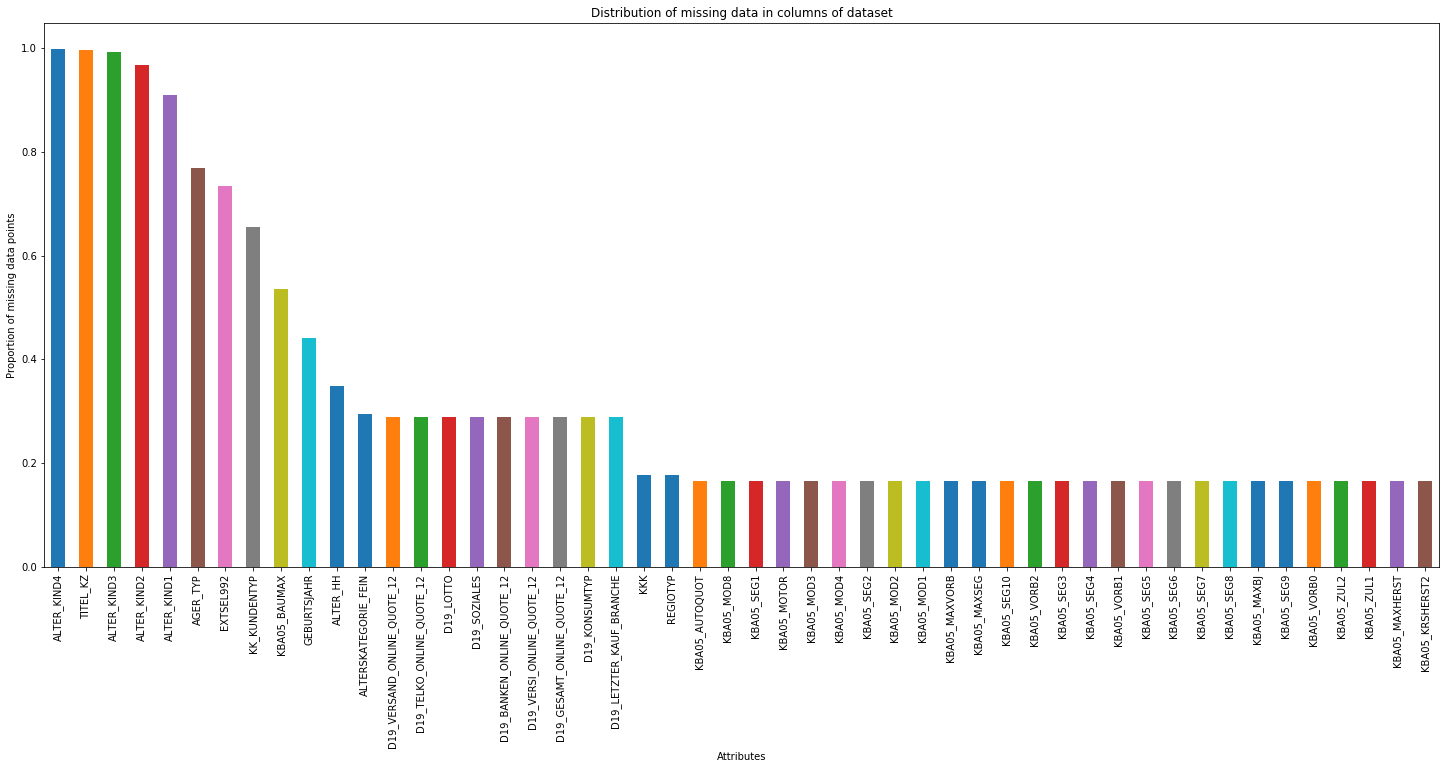

In [11]:
t.show_dist_missing_values_column(azdias)

From the cells above, I see that the most columns have fewer than 20% of missing data points. I will eliminate any column which has more than 20% of missing data points.

In [12]:
n_missing_column_data = azdias.isnull().sum(axis=0).sort_values(ascending=False)

prop_missing_column_data = n_missing_column_data/azdias.shape[0]

columns_to_drop = list(n_missing_column_data[prop_missing_column_data >=0.2].index.values)

print(columns_to_drop)

['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_LOTTO', 'D19_SOZIALES', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE']


I found that the data which represented similar features, but on different scales, tended to have similar amounts of missing data. For example  `CAMEO_DEU_2015`, `CAMEO_DEUG_2015`, and `CAMEO_INTL_2015`, which are data on wealth/lifestyle topology on a rough, detailed and international scale respectively, have almost the same amount of missing data.

The columns with lots of missing data tended to be those of individual records, like people's titles, dates of birth, ageing, etc.

#### Step 1.1.3: Assess Missing Data in Each Row

I now do the same for the rows in the dataset.

In [13]:
# How much data is missing in each row of the dataset?
n_missing_row_data = azdias.isnull().sum(axis=1)

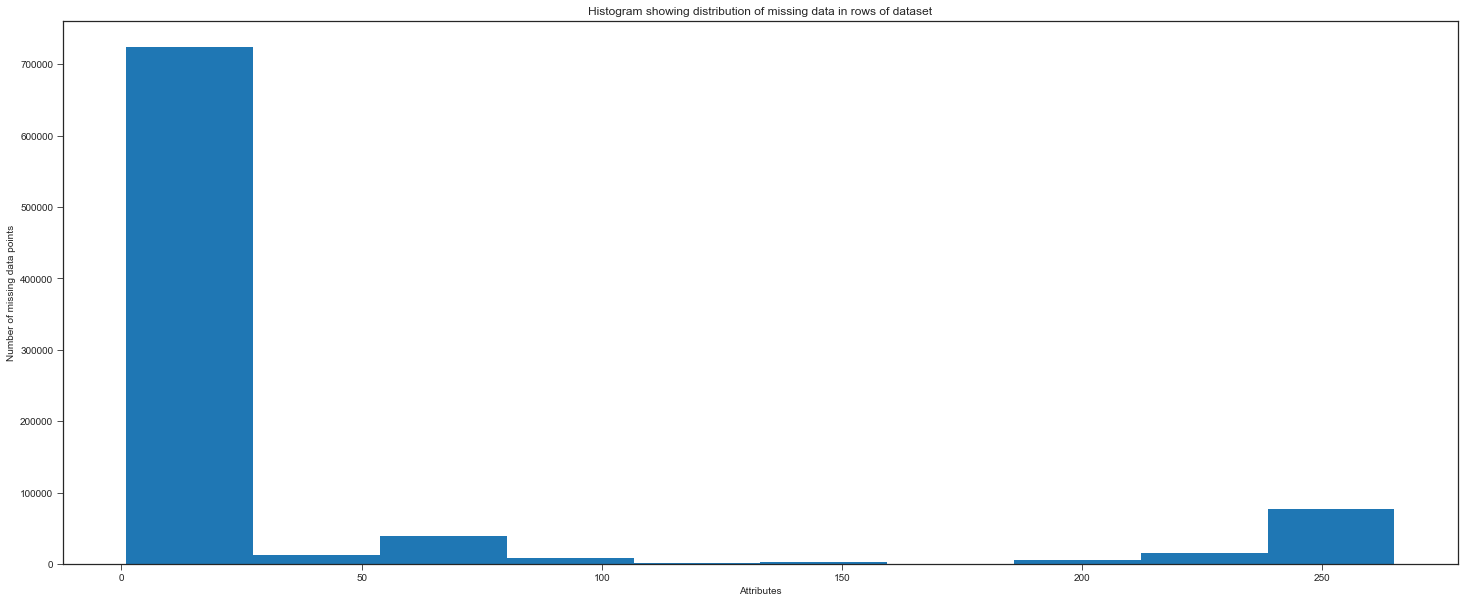

In [14]:
# Investigate patterns in the amount of missing data in each row.
fig = plt.figure(figsize=(25,10))
sns.set_style("ticks")
ax = n_missing_row_data.plot.hist()
ax.set_title("Histogram showing distribution of missing data in rows of dataset")
ax.set_xlabel("Attributes")
ax.set_ylabel("Number of missing data points")
plt.show()

Now I divide the dataset into two subsets based on the number of missing values in each row. The first dataset is comprised of rows with no missing values at all, while the second dataset contains the rest of the datapoints.

In [15]:
i=25
rows_wo_missing_values = list(np.where(n_missing_row_data <=i)[0])
rows_with_missing_values = list(np.where(n_missing_row_data >i)[0])

azdias_few_missing_values = azdias.loc[rows_wo_missing_values, :]
azdias_many_missing_values = azdias.loc[rows_with_missing_values, :]

Now I compare the distribution of values for five columns where there are no or few missing values, between the two subsets.

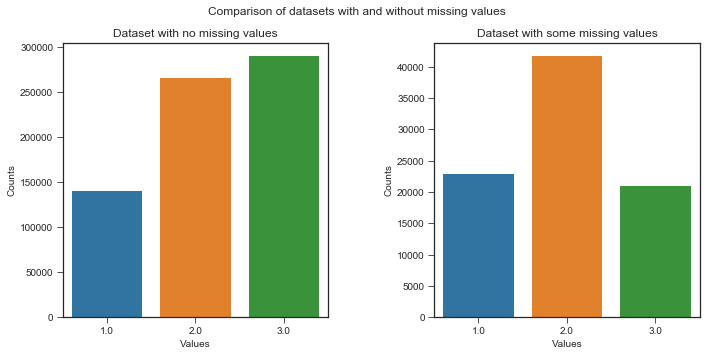

In [16]:
t.compare_distribution('HEALTH_TYP', azdias_few_missing_values, azdias_many_missing_values)

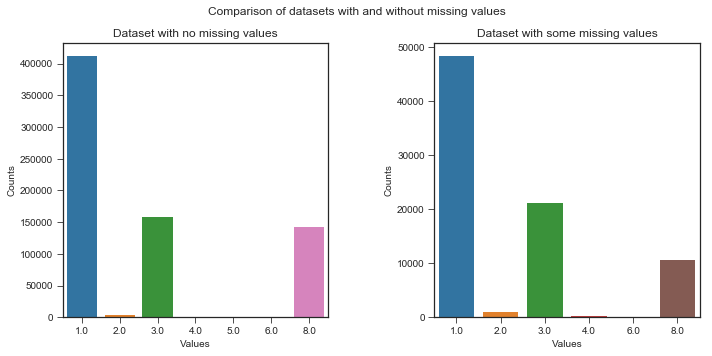

In [17]:
t.compare_distribution('GEBAEUDETYP', azdias_few_missing_values, azdias_many_missing_values)

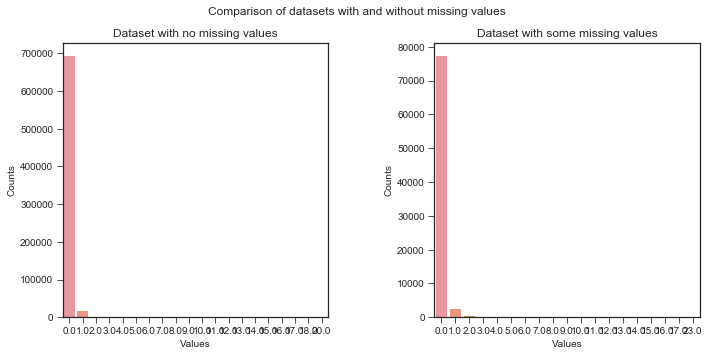

In [18]:
t.compare_distribution('ANZ_HH_TITEL', azdias_few_missing_values, azdias_many_missing_values)

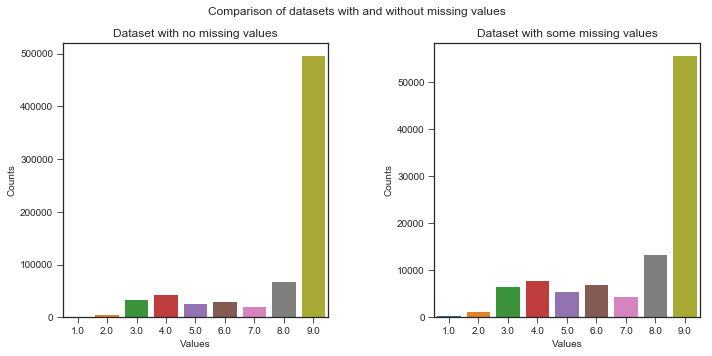

In [20]:
t.compare_distribution('WOHNDAUER_2008', azdias_few_missing_values, azdias_many_missing_values)

From the bar charts above, the distributions of values between both datasets are quite similar. As such, from now on, I will use the dataset with few missing values.

In [21]:
azdias = azdias_few_missing_values

### Step 1.2: Select and Re-Encode Features

In [22]:
# How many features are there of each data type?
for value in feat_info["type"].unique():
    print("There are {} {} features".format(feat_info[feat_info["type"]==value].shape[0],value))

There are 22 categorical features
There are 212 ordinal features
There are 7 numeric features
There are 7 mixed features
There are 1 interval features
There are 0 nan features


#### Step 1.2.1: Re-Encode Categorical Features

In [23]:
cat_features, ord_features, num_features, mixed_features, interval_features = t.attributes_by_type(azdias, feat_info)

In [24]:
print("The following are the categorical features in the dataset: \n")
for each in cat_features:
    print(each)

The following are the categorical features in the dataset: 

AGER_TYP
ANREDE_KZ
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
KK_KUNDENTYP
GEBAEUDETYP
OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015
KBA05_MAXHERST


*OST_WEST_KZ* is binary, but needs to be re-encoded, since it takes on non-numeric values ('W' for West and 'O' for East).

In [25]:
print("The following are the mixed features in the dataset: \n")
for each in mixed_features:
    print(each)

The following are the mixed features in the dataset: 

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
KBA05_BAUMAX
PLZ8_BAUMAX


In [26]:
print("The following are the interval features in the dataset: \n")
for each in interval_features:
    print(each)

The following are the interval features in the dataset: 

ALTER_HH


From looking at the description of the remaining categorical features in the dataset, I came to the following conclusions:

* `CACAMEO_DEUG_2015` and `CAMEO_DEU_2015` both describe the wealth and life stage typology, albeit at different scales. I will keep `CAMEO_DEUG_2015`, that which describes the typology at the rough scale.
* The same is true of `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` and `LP_STATUS_FEIN` and `LP_STATUS_GROB`.

I also drop `GEBAEUDETYP`, which is a building-level feature, which simply describes the types of buildings.

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. 
* `PRAEGENDE_JUGENDJAHRE` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). I create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
* `CAMEO_INTL_2015` combines information on two axes: wealth and life stage. I break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

I created two new columns: `PJ_DECADE` to capture the decade dimension, and `PJ_movement` to capture the movement. For `PJ_decade`, I created six new categories, one for each decade represented in the data. For `PJ_movement`, I created a binary variable. 1 represents the Mainstream movement, while 2 represents the Avantgarde movement. I kept the `PLZ8_BAUMAX` feature, because I found it easy, and reasonable to separate the building types in the region into family and business type buildings. So I grouped all the family homes into one category, irrespective of the size, and left the business buildings in a category of its own.

I will drop the `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` features, because they were too cumbersome to separate appropriately, and the `WOHNLAGE` feature because I didn't find any reasonable way to aggregate the subdivisions between features.

In [27]:
azdias = t.clean_data(azdias, feat_info)

Drop columns with more than 20% missing values
Drop rows with more than 25 missing values
Re-encode 'OST_WEST_KZ'
Imputing missing values for features
One-hot encoding of categorical variables
Re-encoding categorical features done.
Engineering mixed-type features
Engineering mixed-type features done


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

In [28]:
if azdias.isnull().sum().sum() == 0:
    print("There are no NaN values in the dataset at this stage, we can continue with the analysis")
else:
    print("There are still some missing values in this dataset, please go back and clean your data properly")

There are no NaN values in the dataset at this stage, we can continue with the analysis


At this stage I rescale all the data in the dataset, so that differences in units, ranges, etc., do not intefere with the analysis.

### 2.1: Apply Feature Scaling

In [29]:
scaler = StandardScaler()
standard_scaled_azdias = scaler.fit_transform(azdias)
standard_scaled_azdias = pd.DataFrame(standard_scaled_azdias, columns=list(azdias))

/Users/bmsbm/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bmsbm/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Step 2.2: Dimensionality Reduction

In [30]:
# Apply PCA to the data.
pca = PCA()
pca.fit(standard_scaled_azdias);

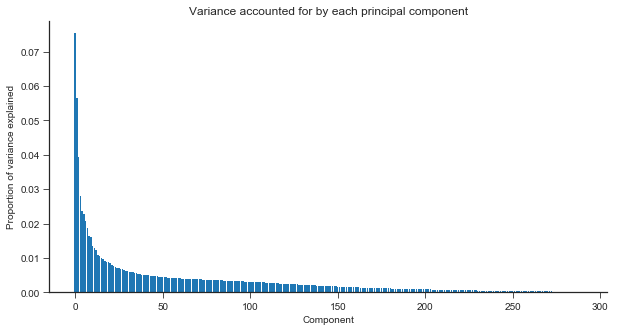

In [31]:
t.pca_variance_explained(pca)

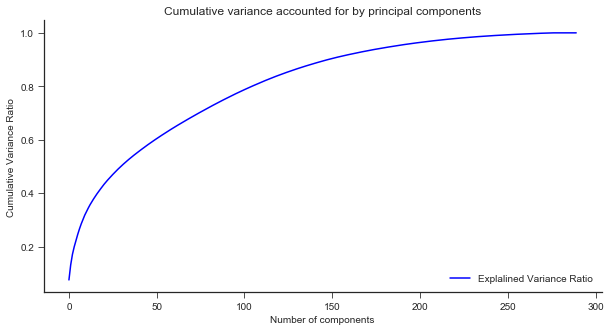

In [32]:
y1 = t.scree_plot(pca)

In [33]:
threshold = 0.90
number_components = int(np.argwhere(y1>=threshold)[1])
print("We retain {} components for analysis because they explain {}% of the variance in the data." 
      .format(number_components, int(threshold*100)))

We retain 149 components for analysis because they explain 90% of the variance in the data.


In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=number_components)
azdias = pca.fit_transform(standard_scaled_azdias);

In [35]:
azdias = pd.DataFrame(azdias)
azdias.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0.460250,5.443414,-4.931613,-0.568317,-4.153886,3.300563,0.823072,0.139253,2.208483,3.447362,...,0.762740,-0.654525,1.755163,0.123976,0.688717,-0.062906,0.082184,-1.413839,0.023688,-0.815258
1,-2.666139,1.485633,0.088738,3.082268,-3.741324,-5.631023,-1.565468,-1.696181,-0.576523,-1.504971,...,1.666393,-0.484829,0.255422,1.551450,0.291942,-0.836788,0.240241,-0.234252,0.494499,0.220005
2,-5.493665,-1.781194,1.423101,-1.405365,-1.875322,1.535724,-2.237451,0.798089,-2.267783,2.242555,...,0.555715,-1.319714,0.492247,-0.759276,-0.315043,-0.290671,-0.908196,-0.657733,0.486530,-0.157349
3,-1.207028,2.326690,0.108211,-0.474516,3.593316,-2.077641,-1.365377,0.423716,-4.526299,0.926511,...,-0.123229,0.236766,2.166383,0.931681,-0.287767,-0.623507,-0.089900,-0.412394,0.655188,-1.136259
4,-3.346742,0.726831,-1.158231,0.596629,-1.828809,0.395601,-2.137830,-0.944972,-0.022268,1.634241,...,-0.951678,0.289120,0.343455,-0.547591,-1.185698,-0.493840,-0.630969,-0.415617,0.239895,0.547337


### Discussion 2.2: Perform Dimensionality Reduction

I decided to retain 149 components for the rest of the analysis, because they explain 90% of the variance in the data.

### Step 2.3: Interpret Principal Components

In [36]:
print(t.pca_results(pca, 0, columns=list(standard_scaled_azdias.columns)))

MOBI_REGIO           -0.146688
PLZ8_ANTG1           -0.145331
KBA05_ANTG1          -0.141622
PLZ8_ANTG3            0.138461
CAMEO_INTL_wealth     0.149299
HH_EINKOMMEN_SCORE    0.150089
Name: 0, dtype: float64


In [37]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(t.pca_results(pca, 1, columns=list(standard_scaled_azdias.columns)))

KBA13_ALTERHALTER_60          -0.150575
KBA13_HALTER_20               -0.136101
KBA13_HALTER_55               -0.135422
KBA13_SEG_OBEREMITTELKLASSE    0.151122
EWDICHTE                       0.159832
KBA13_HERST_BMW_BENZ           0.171551
Name: 1, dtype: float64


In [38]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(t.pca_results(pca, 2, columns=list(standard_scaled_azdias.columns)))

FINANZ_SPARER          -0.234084
PJ_decade              -0.232515
SEMIO_REL              -0.218004
ZABEOTYP_3              0.185896
FINANZ_VORSORGER        0.208312
ALTERSKATEGORIE_GROB    0.229199
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

For the sake of simplicity, I will consider the first three and last three elements in each principal component.

#### First Principal Component:
This component is negatively correlated with the features associated with movement patterns (with high values indicating low movement), low financial interest typology (with high values indicating a low dimension) and number of 1-2 family houses in the KBA05 microcell (high values here indicate a high number of of such houses in the microcell).

It is positively correlated with the features associated with low-income earners, number of 6-10 family houses in the PLZ8 region, and the type of building in the region (with high values suggesting mostly 10+ family buildings and business buildings)

It can be interpreted as a measure of how suburban an area is - positive values for this component would indicate that we are dealing with a suburban, family-oriented, residential area, where people tend to live in the same place for a long time and do not move around very much. A negative value here would indicate that we are dealing with highly mobile, less family-oriented people.


#### Second Principal Component:
This component is negatively correlated with the features indicating decade of a person's youth (with high values indicating those whose youth was in the 80s and 90s - millenials), religious affinity (with high values here indicating low religious affinity), and being a money saver (high values here indicating a low tendency).

It is positively correlated with the features representing age (with high values indicating older people), a financial typology of "be-prepared" (high values indicating a low interest), affinity for events (with high values indicating a low affinity for events) and energy consumption typology (with high values tending to indicate indifference).

This component can be viewed as a measure of a person's stage in life and worldview. A positive value here indicates a an older, more religious, dutiful person, who has a low affinity for events and is generally unprepared for major expenditures.


#### Third Principal Component
This component is negatively correlated with Gender (Higher values indicate females), a combative attitude and being dominant-minded ( with higher values indicating low combativeness and dominant-mindedness respectively)

It is positively correlated with features representing dreamfulness, social-mindedness and family-mindedness. For all three of these features, high values indicate low affinities.

This component can therefore be viewed as a measure of a person's gender and worldview. A positive value here would indicate a male who is combative and dominant-minded, a negative value would indicate a female who is dreamful, family-minded and socially-minded.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

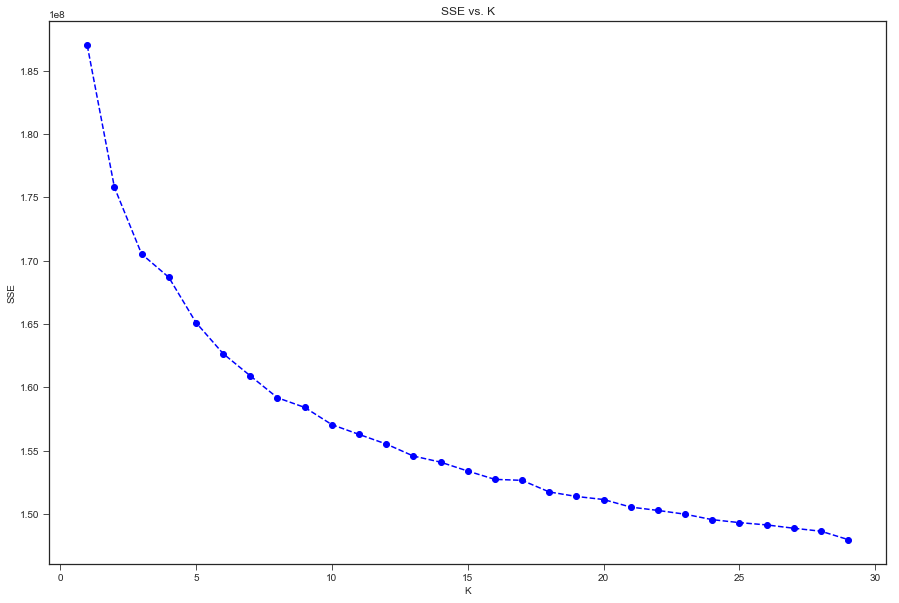

In [39]:
t.scree_plot_clusters(azdias, max_centers=30)

In [40]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 16)
azdias_clusters = kmeans.fit_predict(azdias);

### Discussion 3.1: Apply Clustering to General Population

There is an elbow at K=16 clusters, and so I segment the population into 16 clusters.

### Step 3.2: Applying All Steps to the Customer Data

It's now time to see how the customer data maps on to the clusters from the general population. I will use the fits from the general population to clean, transform, and cluster the customer dataand then interpret how the general population fits apply to the customer data.

In [41]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_052018.csv", sep=";", dtype = {18: 'str', 19: 'str'})

In [42]:
#Clean the customer demographics data.
new_customers = t.clean_data(customers, feat_info)

Drop columns with more than 20% missing values
Drop rows with more than 25 missing values
Re-encode 'OST_WEST_KZ'
Imputing missing values for features
One-hot encoding of categorical variables
Re-encoding categorical features done.
Engineering mixed-type features
Engineering mixed-type features done


In [43]:
standard_scaled_customers = scaler.transform(new_customers)
standard_scaled_customers = pd.DataFrame(standard_scaled_customers, columns=list(new_customers))

customer_df = pd.DataFrame(pca.transform(standard_scaled_customers))

customer_clusters = kmeans.predict(customer_df);

/Users/bmsbm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


### Step 3.3: Compare Customer Data to Demographics Data

Here, I compare the two cluster distributions to see where the strongest customer base for the company is.

In [44]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

K = 16
n_general = []
n_customer = []
for i in range(K):
    n_general.append(np.argwhere(azdias_clusters==i).shape[0]/azdias_clusters.shape[0])
    n_customer.append(np.argwhere(customer_clusters==i).shape[0]/customer_clusters.shape[0])

In [45]:
# A dataframe with the proportion of data in each cluster for the customer data 
# and the general population

label_counts = pd.DataFrame({'General Dataset': n_general})
label_counts['Customer Dataset'] = pd.Series(n_customer)
label_counts['Clusters'] = pd.Series(list(range(K)))

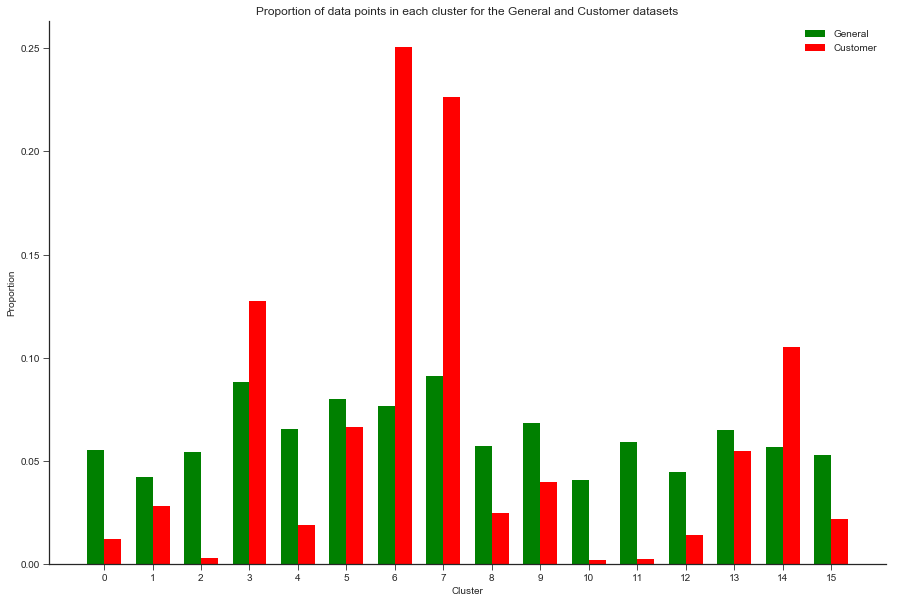

In [46]:
# Plotting bar chart to visualize these proportions

N = K
customer_props = label_counts['Customer Dataset']
general_props = label_counts['General Dataset']

ind = np.arange(N) 
width = 0.35 

plt.figure(figsize=(15,10))
plt.bar(ind, general_props, width, color='green', label='General')
plt.bar(ind + width, customer_props, width, color='red',
    label='Customer')

plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.title('Proportion of data points in each cluster for the General and Customer datasets')

plt.xticks(ind + width / 2, range(N))
plt.legend(loc='best')
sns.despine()
plt.show()

In [47]:
customer_df['labels'] = customer_clusters

In [54]:
# People from cluster 11 are vastly overrepresented in general data compared to 
# customer population. We need to check it out.
customer_df[customer_df.labels==11].head(20)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,labels
615,2.541546,-0.268978,-1.536174,0.066945,-3.128440,-3.311023,1.208914,-0.140270,2.278676,-0.562859,...,0.850386,-1.066725,0.284523,-0.161170,-0.354726,0.794763,1.261513,-1.096410,-0.491802,11
891,6.908519,1.290360,0.098081,-0.805073,-0.753663,-2.059106,3.642403,-0.425583,-1.180314,2.634196,...,0.013991,-1.528582,1.631473,0.758237,0.391584,-1.013170,-0.879443,-0.988720,1.352214,11
1689,4.637611,3.480739,-2.846930,-0.484473,-3.137717,-2.284502,0.260927,1.401312,-0.432154,-4.508472,...,0.245034,0.309117,0.049556,-0.277346,0.292870,-0.396778,1.230849,-0.587004,-0.000572,11
1785,1.736757,2.842079,-1.987520,-2.376865,-1.957643,-3.913171,-2.645547,3.279466,-2.532449,3.270860,...,-0.218156,1.201922,-0.043225,-0.325570,0.638607,-0.369178,1.153931,0.688647,-0.627259,11
2077,2.823281,3.345518,-0.381797,-1.503889,0.246353,0.147179,7.417540,4.220057,-1.685754,-1.849358,...,0.647917,-0.280873,-0.369002,0.025177,1.122592,0.733521,-1.076513,-0.572583,-0.140376,11
2719,7.729814,-0.679545,-1.856299,-2.105838,-0.995464,-4.261543,3.715748,-2.620405,1.103294,0.195406,...,0.630665,1.040287,-0.072240,1.258374,0.529447,1.162151,-0.003062,-0.941672,0.309179,11
2776,4.876148,5.600104,-1.881360,1.040031,-1.809265,-3.219341,1.108276,1.601579,3.147819,0.469408,...,-0.669921,0.436512,-1.697491,-0.026377,0.792795,-0.656861,0.213462,0.590906,0.664621,11
3660,2.256998,3.484697,-2.075723,-2.006263,-3.314120,-2.200823,3.175614,0.941613,1.945187,-1.644111,...,-0.003293,-0.237284,-2.023159,-0.411377,0.911346,-1.340478,-0.376129,0.029280,0.059029,11
3933,0.309854,1.111813,-1.696225,-1.113891,0.891373,-3.352820,3.316667,3.948435,1.716352,4.485794,...,-1.234217,1.313233,1.540929,-0.329925,0.225150,-0.535256,-0.043805,-0.415192,-0.075850,11
4257,3.294639,0.721783,0.470296,0.160482,-1.293820,-2.281277,1.182475,0.599429,-0.064685,-4.235311,...,-0.918780,-1.977526,0.901880,-0.569044,0.037540,-0.046495,-0.138056,-0.097808,1.089206,11


In [55]:
# People from cluster 2 are vastly overrepresented in customer data compared to 
# general population. We need to check it out.

customer_df[customer_df.labels==6].head(15)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,labels
36,-2.692433,-0.505821,-1.114639,0.986702,-1.719897,-1.113283,1.191160,1.351220,-0.057609,0.390031,...,-0.526605,0.137807,-0.063099,0.606680,0.976160,-0.965805,-0.266723,-0.016228,0.399402,6
37,-2.770575,-0.564157,-0.667232,0.829790,-1.681700,-1.021665,1.099244,1.345531,-0.074116,0.350197,...,-0.445800,0.098759,-0.074014,0.621887,0.957958,-0.948174,-0.272885,-0.142860,0.314787,6
38,-2.731504,-0.534989,-0.890936,0.908246,-1.700798,-1.067474,1.145202,1.348375,-0.065863,0.370114,...,-0.486202,0.118283,-0.068556,0.614283,0.967059,-0.956989,-0.269804,-0.079544,0.357095,6
39,-2.699866,-0.511431,-1.188822,1.073955,-1.074135,-0.947235,1.002992,1.209145,-0.023079,0.422602,...,-0.518944,0.145384,-0.062658,0.617024,0.982744,-0.942743,-0.265664,-0.026996,0.348026,6
40,-2.778008,-0.569768,-0.741414,0.917043,-1.035938,-0.855617,0.911075,1.203456,-0.039586,0.382768,...,-0.438140,0.106337,-0.073573,0.632231,0.964542,-0.925112,-0.271826,-0.153628,0.263411,6
43,-2.692433,-0.505821,-1.114639,0.986702,-1.719897,-1.113283,1.191160,1.351220,-0.057609,0.390031,...,-0.526605,0.137807,-0.063099,0.606680,0.976160,-0.965805,-0.266723,-0.016228,0.399402,6
44,-2.692433,-0.505821,-1.114639,0.986702,-1.719897,-1.113283,1.191160,1.351220,-0.057609,0.390031,...,-0.526605,0.137807,-0.063099,0.606680,0.976160,-0.965805,-0.266723,-0.016228,0.399402,6
46,-2.699866,-0.511431,-1.188822,1.073955,-1.074135,-0.947235,1.002992,1.209145,-0.023079,0.422602,...,-0.518944,0.145384,-0.062658,0.617024,0.982744,-0.942743,-0.265664,-0.026996,0.348026,6
51,-2.738937,-0.540599,-0.965118,0.995499,-1.055036,-0.901426,0.957033,1.206300,-0.031333,0.402685,...,-0.478542,0.125861,-0.068115,0.624628,0.973643,-0.933928,-0.268745,-0.090312,0.305719,6
53,-2.731504,-0.534989,-0.890936,0.908246,-1.700798,-1.067474,1.145202,1.348375,-0.065863,0.370114,...,-0.486202,0.118283,-0.068556,0.614283,0.967059,-0.956989,-0.269804,-0.079544,0.357095,6


### Discussion 3.3: Compare Customer Data to Demographics Data

People from Cluster 2 are overrepresented in the customer data compared to the general population. From the data, we see that these people tend to have negative values on the first two components, as well as positive values on the third component.

From the analysis we saw earlier (of the first three principal components), we can infer that we are dealing with younger males, who are combative, dominant-minded, highly mobile, not very religious, not very dutiful, have a high affinity for events, and not family-oriented. They tend to live in the areas with a high proportion of 1-2 family homes in the PLZ8 region and RR2 micro-cell region.

People from Cluster 14 are overrepresented in the general population compared to the customer population. I use the values from the seventh, eigth and ninth principal components (because these all tend to be positive, while the other principal components tend to have mixed values) to infer that these are most likely immigrants to Germany, who live in the poorer parts of East Germany, and come from households with large numbers of adults and children.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [90]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype = {18:'str', 19:'str'})

In [91]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [92]:
response = mailout_train["RESPONSE"]

In [93]:
mailout_train = t.clean_data(mailout_train, feat_info)

Drop columns with more than 20% missing values
Drop rows with more than 25 missing values
Re-encode 'OST_WEST_KZ'
Imputing missing values for features
One-hot encoding of categorical variables
Re-encoding categorical features done.
Engineering mixed-type features
Engineering mixed-type features done


In [94]:
mailout_train.shape

(42962, 290)

In [95]:
mailout_train = scaler.transform(mailout_train)
mailout_train = pd.DataFrame(mailout_train, columns=list(new_customers))

mailout_PCA = pd.DataFrame(pca.transform(mailout_train))

/Users/bmsbm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [96]:
X_train, X_test, y_train, y_test = train_test_split(mailout_train,
                                                   response,
                                                   test_size=0.2,
                                                   random_state=0)

In [97]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = SEED)

rdf = RandomForestClassifier(random_state = SEED) 

params = {'max_depth': [6, 8, 10, 20], 
              'min_samples_split': [5, 10, 15],
              'min_samples_leaf' : [4, 8, 12],
              'n_estimators' : [300, 400, 500],
              'class_weight':[{0:80}, {0:85}, {0:75}]
             }

grid_clf = GridSearchCV(estimator = rdf, 
                        param_grid = params,
                        cv = cv, 
                        n_jobs=-1,
                        verbose=4,
                        scoring='roc_auc')
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 129.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 176.2min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 229.2min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 302.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 315.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [6, 8, 10, 20], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [4, 8, 12], 'n_estimators': [300, 400, 500], 'class_weight': [{0: 80}, {0: 85}, {0: 75}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=4)

In [163]:
best_clf = grid_clf.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]

print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))

Final Roc_auc score on the training data: 0.5279


### Using SMOTE

In [168]:
from imblearn.over_sampling import SMOTE
from collections import Counter
sm = SMOTE(random_state=SEED)
from imblearn import pipeline as pl

In [176]:
pipeline = pl.make_pipeline(sm, RandomForestClassifier(random_state=SEED, n_estimators=1000))

In [177]:
# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

In [178]:
roc_auc_score(y_test, y_pred_bal)

0.502525326893627